# Project: "Integrating Blockchain with AI for Customized Loyalty Rewards using Reinforcement Learning"

<b> Goal </b>: 
The main goal of the project is to modernize customer loyalty programs by integrating blockchain and AI, specifically reinforcement learning. Blockchain will enhance security and transparency by providing a reliable platform for transaction records, reducing fraud risks. Reinforcement learning will tailor rewards in real-time to individual customer behaviors and preferences, promoting greater engagement. This dual-technology approach addresses the main issues of traditional loyalty systems, such as vulnerability to breaches and ineffective reward strategies, by offering a personalized and secure solution

<b> Data Used </b>: Initial dataset was downloaded from Kaggle.<a href="https://www.kaggle.com/datasets/imadali595/global-customer-loyalty-program?rvi=1"> dataset link</a> ,but it was further appended using GANs.

<b> Libraries and framework </b>: For this project we have used Python and its related libraries and deep learning framework like PyTorch. And for the reinforcement point of view, we have used DQN and Actor-Critic method. And for blockchain part we have used Solidity programming language.

<b> Brief view of program flow </b>:
* After loading the data into environment, we did data visualizations and plotted some graphs to see the distribution of the data.
*  We did implementation of the GAN and checked its performance through various metrics.
*  We tweaked some parameters, as the performance was not that good as we expected. This time performance was better as compared to the last case.
*  With the trained GAN, we have generated 80,000 rows of synthetic data, to make a better balance with our original dataset.
*  We merged the synthetic data with original dataset and shuffled it, so that the dataset provides a good distribution of various customer profiles.
* ...........
* ...........
* ........<i> next steps </i> .................

<b> Program </b>:

We start with loading all the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
import torch.nn as nn
import torchvision

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict,deque


from scipy.stats import ks_2samp

import warnings
warnings.filterwarnings("ignore")

In [11]:
# We will use GPU for training 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Loading the data into the environment.

In [3]:
df = pd.read_csv("CustomerLoyaltyProgram.csv")
df.head()

,Loyalty#,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,...,LoyaltyStatus,Product Line,Coupon Response,Count,Quantity Sold,Unit Sale Price,Unit Cost,Revenue,Customer Lifetime Value,Loyalty Count
0,837810.0,Abigail,Goris,Abigail Goris,Canada,British Columbia,Dawson Creek,55.759627,-120.237662,U5I 4F1,...,Bronze,Computers and Home Office,Coupon 6,1.0,3.0,"$1,182.00","$1,004.70","$3,546.00",8842.65,1.0
1,707928.0,Ada,Glaude,Ada Glaude,Germany,Bremen,Bremen,53.079296,8.801694,28759,...,Bronze,Computers and Home Office,Coupon 1,1.0,1.0,$434.00,$368.90,$434.00,3508.57,1.0
2,901442.0,Ada,Staback,Ada Staback,Canada,Manitoba,Winnipeg,49.895136,-97.138374,R2C 0M5,...,Bronze,Computers and Home Office,Coupon 1,1.0,2.0,$201.00,$170.85,$402.00,8044.87,1.0
3,237303.0,Adam,Boner,Adam Boner,Canada,Ontario,Sudbury,46.522099,-80.953035,M5V 1G5,...,Bronze,Computers and Home Office,Coupon 4,1.0,3.0,$757.00,$643.45,"$2,271.00",8660.84,1.0
4,348835.0,Adam,Dunnegan,Adam Dunnegan,Canada,Manitoba,Winnipeg,49.895136,-97.138374,R2C 0M5,...,Bronze,Computers and Home Office,Coupon 1,1.0,2.0,$161.00,$136.85,$322.00,25464.82,1.0


Let's check how many rows and columns our dataset contains. 

In [4]:
print(f"Dataset has {df.shape[0]} rows a and {df.shape[1]} columns.")

Dataset has 89950 rows a and 28 columns.


Let's check for missing values.

In [5]:
df.isna().sum()

Loyalty#                   5505
First Name                 5505
Last Name                  5505
Customer Name              5505
Country                    5505
Province or State          5505
City                       5505
Latitude                   5514
Longitude                  5514
Postal code                5505
Gender                     5505
Education                  5505
Location Code              5505
Income                     5505
Marital Status             5505
Order Year                 5505
Quarter                    5505
MonthsAsMember             5505
LoyaltyStatus              5505
Product Line               5505
Coupon Response            5505
Count                      5505
Quantity Sold              5505
Unit Sale Price            5505
Unit Cost                  5505
Revenue                    5505
Customer Lifetime Value    5505
Loyalty Count              5505
dtype: int64

If we delete the missing values, how many of "%age" rows we are deleting is given by: 

In [6]:
(df.isna().sum()[0]/df.shape[0])*100

6.120066703724291

So, we are dropping only 6% of the missing values and given the number of rows we have it is feasible to drop the missing values.

In [7]:
df.dropna(inplace=True)

In [8]:
# So, we shouldn't have any missing values
df.isna().sum().sum()

0

Before proceeding further let's start with some data visualization. 

<Axes: xlabel='Customer Lifetime Value', ylabel='Count'>

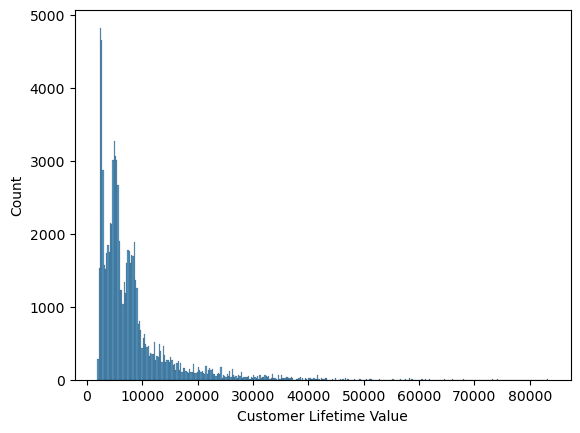

In [9]:
# First start with the distribution of customer lifetime value 
sns.histplot(data=df,x="Customer Lifetime Value")

From above, the distribution appears to be right-skewed. This means that there are more customers with lower CLTV than customers with higher CLTV.

Now let's visualize the loyalty status country-wise. 

In [10]:
df["LoyaltyStatus"].value_counts()

LoyaltyStatus
Platinum    14447
Gold        14390
Bronze      14312
Silver      13985
Elite       13752
VIP         13550
Name: count, dtype: int64

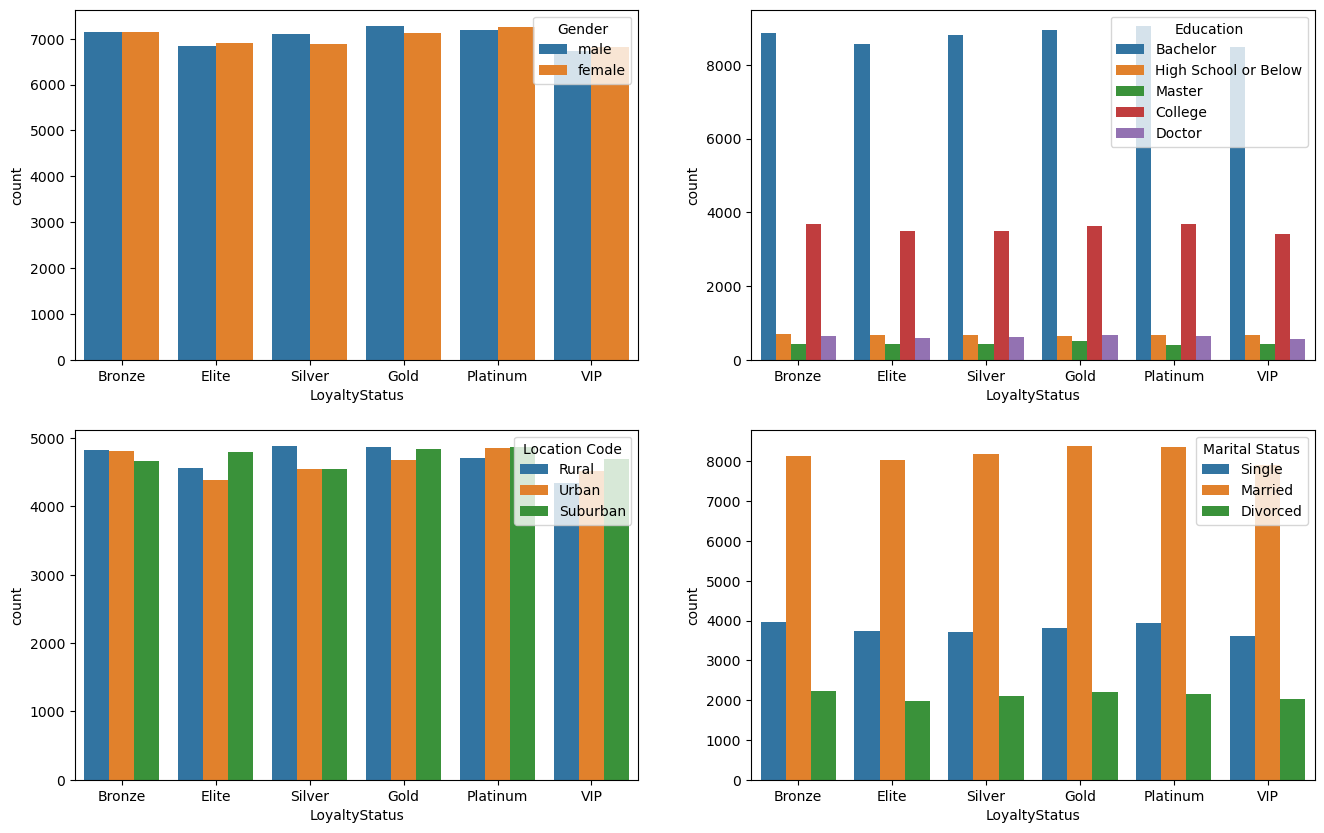

In [11]:
fig,axes = plt.subplots(nrows=2,ncols=2, figsize=(16,10))

sns.countplot(data=df,x="LoyaltyStatus",hue="Gender", ax=axes[0,0]);
sns.countplot(data=df,x="LoyaltyStatus",hue="Education", ax=axes[0,1]);
sns.countplot(data=df,x="LoyaltyStatus",hue="Location Code", ax=axes[1,0]);
sns.countplot(data=df,x="LoyaltyStatus",hue="Marital Status", ax=axes[1,1]);

So, from the above we can say that we can't predict the loyalty tier based on the Gender code and where do they live whether in Rural,Urban or Suburban. And for the Education and Marital Status, they are distributed like this because, we have more number of people with bachelors degree and number of married people are more.  

Let's see how many country of people we have.

In [12]:
df["Country"].value_counts()

Country
United States     22039
Canada            21797
United Kingdom    20774
Germany           19826
Name: count, dtype: int64

Now let's try to find out the relationship between the Customer Lifetime Value, Income, MonthsAsMember.

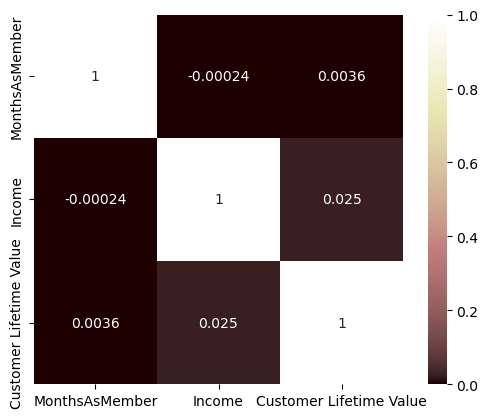

In [13]:
relationship = df[["MonthsAsMember","Income","Customer Lifetime Value"]].corr()
sns.heatmap(relationship,annot=True,cmap="pink",square=True);

So, from above we don't see much relationship between variables. So, if a person is member for a longer duration, it doesn't lead to a higher Customer Lifetime Value. Similalrly, income also don't seems to play a bigger role in customer lifetime value. 

Now we are finished with data visualizations. Since we are building loyalty program, we need to have more data as possible. So, we will train GAN on the existing data that we have to get additional data. 

In [14]:
# Let's take a look at the columns that we have once again
df.columns

Index(['Loyalty#', 'First Name', 'Last Name', 'Customer Name', 'Country',
       'Province or State', 'City', 'Latitude', 'Longitude', 'Postal code',
       'Gender', 'Education', 'Location Code', 'Income', 'Marital Status',
       'Order Year', 'Quarter', 'MonthsAsMember', 'LoyaltyStatus',
       'Product Line', 'Coupon Response', 'Count', 'Quantity Sold',
       'Unit Sale Price', 'Unit Cost', 'Revenue', 'Customer Lifetime Value',
       'Loyalty Count'],
      dtype='object')

We don't need to consider "Loyalty#", "First Name" and "Last Name" to make the program. So, let's make a new dataframe without these columns. 

In [15]:
df_filtered = df.drop(columns=["Loyalty#","First Name","Last Name","Customer Name"])

In [16]:
df_filtered.head()

,Country,Province or State,City,Latitude,Longitude,Postal code,Gender,Education,Location Code,Income,...,LoyaltyStatus,Product Line,Coupon Response,Count,Quantity Sold,Unit Sale Price,Unit Cost,Revenue,Customer Lifetime Value,Loyalty Count
0,Canada,British Columbia,Dawson Creek,55.759627,-120.237662,U5I 4F1,male,Bachelor,Rural,42142.0,...,Bronze,Computers and Home Office,Coupon 6,1.0,3.0,"$1,182.00","$1,004.70","$3,546.00",8842.65,1.0
1,Germany,Bremen,Bremen,53.079296,8.801694,28759,male,High School or Below,Rural,20978.0,...,Bronze,Computers and Home Office,Coupon 1,1.0,1.0,$434.00,$368.90,$434.00,3508.57,1.0
2,Canada,Manitoba,Winnipeg,49.895136,-97.138374,R2C 0M5,female,Bachelor,Rural,71391.0,...,Bronze,Computers and Home Office,Coupon 1,1.0,2.0,$201.00,$170.85,$402.00,8044.87,1.0
3,Canada,Ontario,Sudbury,46.522099,-80.953035,M5V 1G5,female,Bachelor,Urban,79674.0,...,Bronze,Computers and Home Office,Coupon 4,1.0,3.0,$757.00,$643.45,"$2,271.00",8660.84,1.0
4,Canada,Manitoba,Winnipeg,49.895136,-97.138374,R2C 0M5,male,Master,Urban,13663.0,...,Bronze,Computers and Home Office,Coupon 1,1.0,2.0,$161.00,$136.85,$322.00,25464.82,1.0


Let's convert all the non-numerical value into one-hot encoding before processing further.  

In [17]:
cat_cols = [cat for cat in df_filtered if df_filtered[cat].dtype=="object"]

In [18]:
print(cat_cols)

['Country', 'Province or State', 'City', 'Postal code', 'Gender', 'Education', 'Location Code', 'Marital Status', 'Quarter', 'LoyaltyStatus', 'Product Line', 'Coupon Response', 'Unit Sale Price', 'Unit Cost', 'Revenue']


Now, if we look above `Unit Sale Price`, `Unit Cost` & `Revenue` are also in object format. They should be in numerical format of data. So, let's check their sample value and convert them in `float64` format.   

In [19]:
# Checking for Unit Cost
df_filtered["Unit Cost"].sample(5)

32432    $1,178.95 
83351        245.65
79211        254.15
44448       $98.60 
29046      $495.55 
Name: Unit Cost, dtype: object

So, it is because of "$" sign. Let's see whether this is case with the `Revenue`, `Unit Sale Price` and `Unit Cost` as well. 

In [20]:
df_filtered["Revenue"].sample(5)

60414       $336.00 
22501     $7,236.00 
77970           3429
68102       $714.00 
56189    $10,683.00 
Name: Revenue, dtype: object

For the case of "Unit Sale Price".

In [21]:
df_filtered["Unit Sale Price"].sample(5)

38365    $1,180.00 
86596           489
24079      $243.00 
13236      $232.00 
3378       $768.00 
Name: Unit Sale Price, dtype: object

So, this is the same case with all three. We need to remove dollar sign from all three.

In [22]:
df_filtered["Unit Cost"] = df_filtered["Unit Cost"].str.replace("$","")

In [23]:
df_filtered["Unit Sale Price"] = df_filtered["Unit Sale Price"].str.replace("$","")

In [24]:
df_filtered["Revenue"] = df_filtered["Revenue"].str.replace("$","")

In [25]:
df_filtered["Unit Cost"] = df_filtered["Unit Cost"].str.replace(",","")

In [26]:
df_filtered["Unit Sale Price"] = df_filtered["Unit Sale Price"].str.replace(",","")

In [27]:
df_filtered["Revenue"] = df_filtered["Revenue"].str.replace(",","")

In [28]:
df_filtered["Unit Cost"].sample(5)

47056    847.45 
25387    484.50 
37669    277.10 
31418    118.15 
17304    393.55 
Name: Unit Cost, dtype: object

In [29]:
df_filtered["Unit Sale Price"].sample(5)

82287        183
53452    799.00 
20748    598.00 
1156     631.00 
61010    831.00 
Name: Unit Sale Price, dtype: object

In [30]:
df_filtered["Revenue"].sample(5)

81431        1630
1492     1222.00 
60775    1370.00 
28594     362.00 
75872        9864
Name: Revenue, dtype: object

So, we don't have any dollar sign with us. Now change them to the `float64` type.    

In [31]:
df_filtered["Unit Cost"] = df_filtered["Unit Cost"].astype("float64")
df_filtered["Unit Sale Price"] = df_filtered["Unit Sale Price"].astype("float64")
df_filtered["Revenue"] = df_filtered["Revenue"].astype("float64")

In [32]:
print(df_filtered["Unit Cost"].dtype), print(df_filtered["Unit Sale Price"].dtype), print(df_filtered["Revenue"].dtype)

float64
float64
float64


(None, None, None)

Now let's remove these three columns from the list, as they are of numerical type now.

In [33]:
cat_cols

['Country',
 'Province or State',
 'City',
 'Postal code',
 'Gender',
 'Education',
 'Location Code',
 'Marital Status',
 'Quarter',
 'LoyaltyStatus',
 'Product Line',
 'Coupon Response',
 'Unit Sale Price',
 'Unit Cost',
 'Revenue']

In [34]:
cat_cols.remove("Unit Cost")

In [35]:
cat_cols.remove("Unit Sale Price")

In [36]:
cat_cols.remove("Revenue")

Let's checkk the data type of all the columns once for remaining possible `float` type of data.

In [37]:
df[cat_cols].dtypes

Country              object
Province or State    object
City                 object
Postal code          object
Gender               object
Education            object
Location Code        object
Marital Status       object
Quarter              object
LoyaltyStatus        object
Product Line         object
Coupon Response      object
dtype: object

Now convert all the categorical columns into one-hot encode format.

In [38]:
df_coded = pd.get_dummies(data=df_filtered, columns=cat_cols,dtype="int") 

In [39]:
df_coded.head()

,Latitude,Longitude,Income,Order Year,MonthsAsMember,Count,Quantity Sold,Unit Sale Price,Unit Cost,Revenue,...,Product Line_Kitchen Appliances,Product Line_Photography,Product Line_Smart Electronics,Product Line_TV and Video Gaming,Coupon Response_Coupon 1,Coupon Response_Coupon 2,Coupon Response_Coupon 3,Coupon Response_Coupon 4,Coupon Response_Coupon 5,Coupon Response_Coupon 6
0,55.759627,-120.237662,42142.0,2016.0,33.0,1.0,3.0,1182.0,1004.70,3546.0,...,0,0,0,0,0,0,0,0,0,1
1,53.079296,8.801694,20978.0,2016.0,52.0,1.0,1.0,434.0,368.90,434.0,...,0,0,0,0,1,0,0,0,0,0
2,49.895136,-97.138374,71391.0,2016.0,47.0,1.0,2.0,201.0,170.85,402.0,...,0,0,0,0,1,0,0,0,0,0
3,46.522099,-80.953035,79674.0,2016.0,55.0,1.0,3.0,757.0,643.45,2271.0,...,0,0,0,0,0,0,0,1,0,0
4,49.895136,-97.138374,13663.0,2016.0,58.0,1.0,2.0,161.0,136.85,322.0,...,0,0,0,0,1,0,0,0,0,0


In [40]:
print(df_coded.columns)

Index(['Latitude', 'Longitude', 'Income', 'Order Year', 'MonthsAsMember',
       'Count', 'Quantity Sold', 'Unit Sale Price', 'Unit Cost', 'Revenue',
       ...
       'Product Line_Kitchen Appliances', 'Product Line_Photography',
       'Product Line_Smart Electronics', 'Product Line_TV and Video Gaming',
       'Coupon Response_Coupon 1', 'Coupon Response_Coupon 2',
       'Coupon Response_Coupon 3', 'Coupon Response_Coupon 4',
       'Coupon Response_Coupon 5', 'Coupon Response_Coupon 6'],
      dtype='object', length=431)


But since we have to make a GAN, we will only sytandard scale the numerical data. 

In [41]:
# Separating out the numerical variables.
num_cols = [cont_cols for cont_cols in df_coded if df_coded[cont_cols].dtype == "float64"]

In [42]:
print(num_cols)

['Latitude', 'Longitude', 'Income', 'Order Year', 'MonthsAsMember', 'Count', 'Quantity Sold', 'Unit Sale Price', 'Unit Cost', 'Revenue', 'Customer Lifetime Value', 'Loyalty Count']


In [114]:
scaler = StandardScaler()
df_coded[num_cols] = scaler.fit_transform(df_coded[num_cols])

Now we need to convert the data into tensor format.

In [44]:
# Prepare data for GAN 
tensor_features = torch.tensor(df_coded.values, dtype=torch.float32)

# Create dataset 
dataset = torch.utils.data.TensorDataset(tensor_features)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)

In [45]:
next(iter(dataloader))[0].shape[0]

64

In [46]:
next(iter(dataloader))[0].shape[1]

431

In [47]:
data_dim = next(iter(dataloader))[0].shape[1]

Now we define the Generator and Discriminator class. Here we have used `LeakyReLU` as an activation function in hidden layers <i> (and `Tanh` as an activation function in output layer in Generator class) </i>, because this is what structure followed in original GAN paper. 

In [48]:
# Defining the class Generator 
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim,256),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(256,512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(512,1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )

    def forward(self,z):
        return self.model(z)

# Defining the Discriminator 
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256,1),
            nn.Sigmoid()
            
        )

    def forward(self,data):
        return self.model(data)

generator = Generator(100,data_dim).to(device)
discriminator = Discriminator(data_dim).to(device)

# Next we define the learning rate and parameters. It is set according to GAN paper
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Setting the loss function 
criterion = nn.BCELoss()

# Step-5: Training Loop 
epochs = 50
noise_dim = 100

Now we train the model of Generator and Discriminator.

In [49]:
for epoch in range(epochs):
    for data in dataloader:
        real_data = data[0].to(device)

        # Training the discriminator 
        discriminator.zero_grad()
        real_labels = torch.ones(real_data.size(0), 1).to(device)
        fake_labels = torch.zeros(real_data.size(0), 1).to(device)

        real_output = discriminator(real_data)
        lossD_real = criterion(real_output, real_labels)

        noise = torch.randn(real_data.size(0), noise_dim).to(device)
        fake_data = generator(noise)
        fake_output = discriminator(fake_data.detach())
        lossD_fake = criterion(fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake) / 2
        lossD.backward()
        optimizer_D.step()

        # Training the generator 
        generator.zero_grad()
        fake_output = discriminator(fake_data)
        lossG = criterion(fake_output, real_labels)
        lossG.backward()
        optimizer_G.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}')

Epoch [1/50], Loss D: 0.6235, Loss G: 0.9623
Epoch [2/50], Loss D: 0.5556, Loss G: 1.5043
Epoch [3/50], Loss D: 0.3675, Loss G: 1.9724
Epoch [4/50], Loss D: 0.2276, Loss G: 2.7040
Epoch [5/50], Loss D: 0.1733, Loss G: 3.4072
Epoch [6/50], Loss D: 0.0990, Loss G: 4.0609
Epoch [7/50], Loss D: 0.1169, Loss G: 4.9974
Epoch [8/50], Loss D: 0.0128, Loss G: 9.4993
Epoch [9/50], Loss D: 0.0270, Loss G: 9.1082
Epoch [10/50], Loss D: 0.0207, Loss G: 7.9553
Epoch [11/50], Loss D: 0.0292, Loss G: 10.7360
Epoch [12/50], Loss D: 0.0094, Loss G: 6.8176
Epoch [13/50], Loss D: 0.0306, Loss G: 6.0829
Epoch [14/50], Loss D: 0.0053, Loss G: 7.5276
Epoch [15/50], Loss D: 0.0091, Loss G: 8.5767
Epoch [16/50], Loss D: 0.0011, Loss G: 11.0097
Epoch [17/50], Loss D: 0.0168, Loss G: 8.0335
Epoch [18/50], Loss D: 0.0566, Loss G: 19.8280
Epoch [19/50], Loss D: 0.0321, Loss G: 6.0196
Epoch [20/50], Loss D: 0.0511, Loss G: 15.9324
Epoch [21/50], Loss D: 0.0018, Loss G: 9.4658
Epoch [22/50], Loss D: 0.0054, Loss G: 

Next we save the model. 

In [50]:
torch.save(generator.state_dict(), "generator_final.pth")
torch.save(discriminator.state_dict(), "discriminator_final.pth")

In [51]:
# Laoding the model
generator.load_state_dict(torch.load('generator_final.pth'))
discriminator.load_state_dict(torch.load('discriminator_final.pth'))

<All keys matched successfully>

So, since we have trained the GAN, now we can generate new synthetic data. Let's try it. We start with 80000 new samples to set it equal to the data that we have originally. 

In [52]:
# For generating new data we need to set it to evaluation mode
generator.eval()

# Generating noise vector z
num_samples = 80000 # Suppose we want to generate 80000 samples  
noise_dim = 100 # We need to keep this same on which our GAN was trained
noise = torch.randn(num_samples,noise_dim).to(device)

# Generating the synthetic sample data 
with torch.no_grad():
    synthetic_data = generator(noise).cpu().numpy() # Move generated data to CPU and convert to numpy

In [53]:
synthetic_data

array([[ 0.5933337 ,  0.9999887 , -0.9067582 , ...,  0.06061419,
        -0.1057446 ,  0.63150597],
       [ 0.5965479 ,  0.9218457 , -0.5154658 , ...,  0.0489103 ,
         0.01184886, -0.02798675],
       [ 0.67349875,  0.8926311 , -0.2630735 , ...,  0.0526567 ,
        -0.22243504,  0.04359005],
       ...,
       [ 0.02505729, -0.7692233 , -0.45016947, ...,  0.01118993,
         0.15855846,  0.05746314],
       [ 0.5575442 ,  0.9999952 , -0.90739   , ...,  0.07995003,
        -0.08963908,  0.6466013 ],
       [ 0.5615332 ,  0.84157467, -0.24239387, ...,  0.06908576,
        -0.17049582, -0.1718945 ]], dtype=float32)

But its hard to interpret, whether it actually resembles to original data or not. For this, we need to convert back into datframe format. So, let's convert the data into dataframe format. 

In [54]:
len(df_coded.columns)

431

We will create a new dataframe for this synthetic data.

In [55]:
synthetic_df = pd.DataFrame(synthetic_data, columns=df_coded.columns)

In [56]:
synthetic_df.head()

,Latitude,Longitude,Income,Order Year,MonthsAsMember,Count,Quantity Sold,Unit Sale Price,Unit Cost,Revenue,...,Product Line_Kitchen Appliances,Product Line_Photography,Product Line_Smart Electronics,Product Line_TV and Video Gaming,Coupon Response_Coupon 1,Coupon Response_Coupon 2,Coupon Response_Coupon 3,Coupon Response_Coupon 4,Coupon Response_Coupon 5,Coupon Response_Coupon 6
0,0.593334,0.999989,-0.906758,-0.999571,0.999876,0.144257,0.844319,-0.463392,-0.433044,0.603666,...,0.064682,0.047036,-0.009339,-0.098125,-0.592286,0.982130,-0.390216,0.060614,-0.105745,0.631506
1,0.596548,0.921846,-0.515466,-0.701384,0.998437,0.030280,-0.007086,-0.482473,-0.335039,-0.317053,...,0.042345,0.012888,0.020487,0.964803,-0.039753,0.994663,-0.380905,0.048910,0.011849,-0.027987
2,0.673499,0.892631,-0.263074,-0.027028,-0.231558,0.025547,0.574546,-0.915630,-0.894836,-0.444029,...,0.014938,0.042157,0.146114,0.734648,0.165410,0.954760,-0.370279,0.052657,-0.222435,0.043590
3,0.556082,0.875178,-0.116295,0.989444,0.807526,0.024866,-0.617413,-0.705195,-0.634955,-0.764199,...,-0.031963,-0.009188,-0.062738,0.993618,0.829532,0.323312,-0.268328,0.049487,-0.223242,-0.013790
4,0.191201,0.999979,0.992763,0.048234,-0.704200,0.042793,-0.458771,0.061954,0.082048,-0.262491,...,0.011500,-0.004836,0.069829,0.990825,0.976640,0.095474,-0.024967,0.041251,-0.001600,-0.019889


So, we have converted the data into pandas format.

Let's save this synthetic data, so that we may not need to build it again and again.

In [57]:
synthetic_df.to_csv("synthetic_df.csv",index=False)

In [58]:
sum(df_coded.columns == synthetic_df.columns)

431

Let's plot the value of numerical data to see the compariosn that how it feels like.

In [61]:
ks_results = {}

for col in num_cols:
    # Applying ks_2samp to each column individually
    ks_stat, ks_pvalue = ks_2samp(df_coded[col], synthetic_df[col])
    ks_results[col] = (ks_stat, ks_pvalue)
    print(f"KS Statistic for {col}: {ks_stat:.4f}, P-value: {ks_pvalue:.4f}")

print(ks_results)

KS Statistic for Latitude: 0.2573, P-value: 0.0000
KS Statistic for Longitude: 0.2704, P-value: 0.0000
KS Statistic for Income: 0.2552, P-value: 0.0000
KS Statistic for Order Year: 0.3411, P-value: 0.0000
KS Statistic for MonthsAsMember: 0.1803, P-value: 0.0000
KS Statistic for Count: 0.9914, P-value: 0.0000
KS Statistic for Quantity Sold: 0.3706, P-value: 0.0000
KS Statistic for Unit Sale Price: 0.2452, P-value: 0.0000
KS Statistic for Unit Cost: 0.2198, P-value: 0.0000
KS Statistic for Revenue: 0.4618, P-value: 0.0000
KS Statistic for Customer Lifetime Value: 0.2742, P-value: 0.0000
KS Statistic for Loyalty Count: 0.8759, P-value: 0.0000
{'Latitude': (0.2572797183665735, 0.0), 'Longitude': (0.27036470522052203, 0.0), 'Income': (0.2551666036998436, 0.0), 'Order Year': (0.341122270121749, 0.0), 'MonthsAsMember': (0.18031408403998295, 0.0), 'Count': (0.9914, 0.0), 'Quantity Sold': (0.370625, 0.0), 'Unit Sale Price': (0.24522503256904638, 0.0), 'Unit Cost': (0.21977820183334118, 0.0), 'R

To have a better closer resemblence, we try GAN architecture with Batch Normalization and this time we are going to use label smoothing and early stopping as well. 

In [63]:
# Defining the class Generator 
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Linear(256,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Linear(512,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )

    def forward(self,z):
        return self.model(z)

# Defining the Discriminator 
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2,inplace=True),
            nn.BatchNorm1d(512),
            
            nn.Linear(512,256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(256),
            
            nn.Linear(256,1),
            nn.Sigmoid()
            
        )

    def forward(self,data):
        return self.model(data)

generator = Generator(100,data_dim).to(device)
discriminator = Discriminator(data_dim).to(device)

# Next we define the learning rate and parameters. It is set according to GAN paper
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Setting the loss function 
criterion = nn.BCELoss()

# Step-5: Training Loop 
epochs = 50
noise_dim = 100

This time we set the `EarlyStopping` as well, so that if performance doesn't improve we can stop the training. We set the patience to 10 epochs,i.e. if the training metrics doesn't improve after 10 epochs, stop the training.  

In [64]:
class EarlyStopping:
    def __init__(self,patience=10,min_delta=0):
        self.patience = 10
        self.min_delta = min_delta
        self.counter = 0 
        self.best_loss = np.Inf
        self.early_stop = False

    def __call__(self,val_loss):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0 
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping counter: {self.counter} out of {self.patience}")
                self.early_stop = True

# Initializing early stopping object 
early_stopping = EarlyStopping(patience=5,min_delta=0.001)

In [65]:
for epoch in range(epochs):
    for data in dataloader:
        real_data = data[0].to(device)

        # Training the discriminator 
        discriminator.zero_grad()
        real_labels = torch.full((real_data.size(0), 1), 0.9, device=device) # Smoothed labels for real data
        fake_labels = torch.full((real_data.size(0), 1), 0.1, device=device) # Smoothed labels for fake data
        
        real_output = discriminator(real_data)
        lossD_real = criterion(real_output, real_labels)

        noise = torch.randn(real_data.size(0), noise_dim).to(device)
        fake_data = generator(noise)
        fake_output = discriminator(fake_data.detach())
        lossD_fake = criterion(fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake) / 2
        lossD.backward()
        optimizer_D.step()

        # Training the generator 
        generator.zero_grad()
        fake_output = discriminator(fake_data)
        lossG = criterion(fake_output, real_labels)
        lossG.backward()
        optimizer_G.step()

    val_loss = lossG.item()
    print(f'Epoch [{epoch+1}/{epochs}], Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}')

    # Calling the early stopping function
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

Epoch [1/50], Loss D: 0.6936, Loss G: 0.6932
Epoch [2/50], Loss D: 0.6933, Loss G: 0.6932
Epoch [3/50], Loss D: 0.6932, Loss G: 0.6931
Epoch [4/50], Loss D: 0.6932, Loss G: 0.6931
Epoch [5/50], Loss D: 0.6932, Loss G: 0.6932
Epoch [6/50], Loss D: 0.6932, Loss G: 0.6931
Epoch [7/50], Loss D: 0.6931, Loss G: 0.6932
Epoch [8/50], Loss D: 0.6931, Loss G: 0.6932
Epoch [9/50], Loss D: 0.6931, Loss G: 0.6932
Epoch [10/50], Loss D: 0.6931, Loss G: 0.6932
Epoch [11/50], Loss D: 0.6931, Loss G: 0.6932
Early stopping counter: 10 out of 10
Early stopping triggered.


Now saving the model.

In [66]:
torch.save(generator.state_dict(), "generator_final.pth")
torch.save(discriminator.state_dict(), "discriminator_final.pth")

In [67]:
# Loading the model
generator.load_state_dict(torch.load('generator_final.pth'))
discriminator.load_state_dict(torch.load('discriminator_final.pth'))

<All keys matched successfully>

In [68]:
# For generating new data we need to set it to evaluation mode
generator.eval()

# Generating noise vector z
num_samples = 80000 # Suppose we want to generate 80000 samples  
noise_dim = 100 # We need to keep this same on which our GAN was trained
noise = torch.randn(num_samples,noise_dim).to(device)

# Generating the synthetic sample data 
with torch.no_grad():
    synthetic_data = generator(noise).cpu().numpy() # Move generated data to CPU and converting to numpy

In [69]:
synthetic_data

array([[ 0.88696355, -0.450787  , -0.9512815 , ..., -0.38077942,
        -0.9228639 , -0.26156703],
       [ 0.86188364, -0.6794872 , -0.9176569 , ..., -0.22293518,
         0.44291303, -0.82115746],
       [ 0.8972552 , -0.32506698, -0.80653864, ...,  0.24721181,
         0.2317901 , -0.35700035],
       ...,
       [ 0.89503103, -0.5556281 , -0.94097495, ...,  0.7048373 ,
        -0.9888735 , -0.06063901],
       [-0.51974046, -0.949247  , -0.7258627 , ..., -0.38719016,
         0.94379115, -0.7296179 ],
       [-0.49940595, -0.7676695 , -0.64528733, ...,  0.8150666 ,
         0.55018204, -0.9734348 ]], dtype=float32)

Let's put this synthetic data into a dataframe.

In [70]:
synthetic_df = pd.DataFrame(synthetic_data, columns=df_coded.columns)

In [71]:
synthetic_df.head()

,Latitude,Longitude,Income,Order Year,MonthsAsMember,Count,Quantity Sold,Unit Sale Price,Unit Cost,Revenue,...,Product Line_Kitchen Appliances,Product Line_Photography,Product Line_Smart Electronics,Product Line_TV and Video Gaming,Coupon Response_Coupon 1,Coupon Response_Coupon 2,Coupon Response_Coupon 3,Coupon Response_Coupon 4,Coupon Response_Coupon 5,Coupon Response_Coupon 6
0,0.886964,-0.450787,-0.951281,0.660179,-0.538931,-0.747847,0.842171,0.684459,0.928024,-0.593665,...,-0.776835,0.752706,-0.917850,-0.097264,-0.366804,-0.597272,-0.936832,-0.380779,-0.922864,-0.261567
1,0.861884,-0.679487,-0.917657,-0.320967,0.009164,0.421453,0.758884,-0.915702,-0.788813,-0.284351,...,0.015837,-0.556568,0.229777,-0.538306,0.475167,-0.065795,0.822789,-0.222935,0.442913,-0.821157
2,0.897255,-0.325067,-0.806539,-0.365631,0.413878,0.149943,0.622994,0.749283,0.903246,0.224070,...,-0.915119,0.449452,-0.584097,-0.566052,-0.045834,-0.952910,-0.049495,0.247212,0.231790,-0.357000
3,0.987543,0.304933,-0.989801,0.806196,0.030854,-0.894212,0.778155,0.208535,0.986039,0.670383,...,-0.840462,-0.813389,-0.974727,0.143708,0.123441,-0.760938,-0.989335,-0.766487,-0.981904,0.821573
4,0.869868,-0.420537,-0.989176,0.855226,-0.377232,-0.794725,0.497036,-0.449480,0.908559,-0.487586,...,-0.309474,-0.808683,-0.858931,0.102388,-0.176024,-0.201773,-0.925904,-0.810095,-0.860086,0.579379


In [72]:
ks_results = {}

for col in num_cols:
    # Applying ks_2samp to each column individually
    ks_stat, ks_pvalue = ks_2samp(df_coded[col], synthetic_df[col])
    ks_results[col] = (ks_stat, ks_pvalue)
    print(f"KS Statistic for {col}: {ks_stat:.4f}, P-value: {ks_pvalue:.4f}")

print(ks_results)

KS Statistic for Latitude: 0.3164, P-value: 0.0000
KS Statistic for Longitude: 0.4858, P-value: 0.0000
KS Statistic for Income: 0.6594, P-value: 0.0000
KS Statistic for Order Year: 0.3411, P-value: 0.0000
KS Statistic for MonthsAsMember: 0.1973, P-value: 0.0000
KS Statistic for Count: 0.6072, P-value: 0.0000
KS Statistic for Quantity Sold: 0.7189, P-value: 0.0000
KS Statistic for Unit Sale Price: 0.1989, P-value: 0.0000
KS Statistic for Unit Cost: 0.2004, P-value: 0.0000
KS Statistic for Revenue: 0.2551, P-value: 0.0000
KS Statistic for Customer Lifetime Value: 0.3769, P-value: 0.0000
KS Statistic for Loyalty Count: 0.7543, P-value: 0.0000
{'Latitude': (0.31641242894026245, 0.0), 'Longitude': (0.4857514750817188, 0.0), 'Income': (0.6593932676820313, 0.0), 'Order Year': (0.341122270121749, 0.0), 'MonthsAsMember': (0.1972856080344877, 0.0), 'Count': (0.60725, 0.0), 'Quantity Sold': (0.718891318868729, 0.0), 'Unit Sale Price': (0.1989080486996068, 0.0), 'Unit Cost': (0.20041162478089916, 

We see there is much lower diffence in Income, Order Year, MonthsAsMember, Count, Quantity Sold, Unit Sale Price, Unit Cost, Revenue, Customer Lifetime Value, and Loyalty Count. A lower KS statistic indicates that the distributions of the synthetic and real datasets are more similar. A high KS statistic suggests greater divergence. We still see through p-value is still less than 0.05, which makes the difference significant. 

Moreover, when dealing with high-dimensional data and especially after standardization, the Kolmogorov-Smirnov (KS) test may not always be the best method for evaluating the performance of a GAN. The test is more suited to one-dimensional data, and with many features, it's likely to find significant differences just by chance. Further, the KS test does not take into account the dependencies between features. 

So, we see that we have much lower loss in case of Generator and statistics with KS value has improved, we will proceed with this new dataset.

Another reason for going ahead with this dataset is that we use GAN to generate synthetic data for a loyalty program, it's entirely possible and even expected that the synthetic dataset will represent different profiles of customers that may not be present in the original dataset. So, GANs can generate a diverse range of customer profiles by learning the underlying distribution of the original data and sampling from that learned space. This can introduce variability that might not be captured in the original dataset, which could be due to limited size or inherent biases in the data collection process. Also,  synthetic data can help fill in gaps in the dataset, especially for underrepresented groups or scenarios, leading to a more robust understanding of customer behaviors and preferences.

So, let's make a new dataframe by merging both of the dataframe.

In [73]:
df_combined = pd.concat([df_coded,synthetic_df],axis=0)

In [74]:
df_combined.shape

(164436, 431)

In [75]:
# Let's shuffle it 
df_combined = df_combined.sample(frac=1)

In [76]:
df_combined.shape

(164436, 431)

In [77]:
df_combined.head()

,Latitude,Longitude,Income,Order Year,MonthsAsMember,Count,Quantity Sold,Unit Sale Price,Unit Cost,Revenue,...,Product Line_Kitchen Appliances,Product Line_Photography,Product Line_Smart Electronics,Product Line_TV and Video Gaming,Coupon Response_Coupon 1,Coupon Response_Coupon 2,Coupon Response_Coupon 3,Coupon Response_Coupon 4,Coupon Response_Coupon 5,Coupon Response_Coupon 6
11623,0.954747,-1.225422,-0.072900,-1.516170,0.370466,0.000000,-0.267581,-1.308948,-1.308948,-0.463616,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
64551,0.754316,-0.783250,-0.911481,-0.335719,-0.690512,-0.144111,0.647747,-0.444659,-0.596871,0.080603,...,-0.044844,0.062272,-0.144870,-0.476423,0.093948,-0.625530,0.712858,-0.711875,0.103468,-0.499846
28226,0.692035,-0.322771,-0.725538,-0.276630,-0.603154,-0.155634,0.770169,-0.013206,0.635349,-0.335947,...,-0.704893,0.504608,-0.241771,0.088610,0.044942,-0.372551,0.045228,0.272207,-0.273955,-0.476667
38675,0.738697,0.306985,-0.829530,-0.742904,-0.280061,0.580947,0.944789,0.351993,-0.068530,0.637460,...,-0.019995,0.616165,0.411990,-0.644461,0.330920,-0.325639,0.905437,0.602717,0.160063,-0.947912
73762,0.909311,-0.013320,-0.883239,0.625765,0.568640,-0.099517,0.676927,0.649521,0.796821,0.883315,...,0.158500,-0.535905,-0.405617,-0.299079,-0.511529,0.204424,-0.079489,0.757922,-0.833225,0.170388


Now we have finished with the data part. Now we will use Reinforcement Learning algortihms on this data.

In [80]:
df_combined.to_csv("final_df.csv",index=False)

In [93]:
cat_cols

['Country',
 'Province or State',
 'City',
 'Postal code',
 'Gender',
 'Education',
 'Location Code',
 'Marital Status',
 'Quarter',
 'LoyaltyStatus',
 'Product Line',
 'Coupon Response']

In [94]:
num_cols

['Latitude',
 'Longitude',
 'Income',
 'Order Year',
 'MonthsAsMember',
 'Count',
 'Quantity Sold',
 'Unit Sale Price',
 'Unit Cost',
 'Revenue',
 'Customer Lifetime Value',
 'Loyalty Count']

In [104]:
print(df_combined[num_cols].columns)

Index(['Latitude', 'Longitude', 'Income', 'Order Year', 'MonthsAsMember',
       'Count', 'Quantity Sold', 'Unit Sale Price', 'Unit Cost', 'Revenue',
       'Customer Lifetime Value', 'Loyalty Count'],
      dtype='object')


In [102]:
df_combined.dtypes

Latitude                    float64
Longitude                   float64
Income                      float64
Order Year                  float64
MonthsAsMember              float64
                             ...   
Coupon Response_Coupon 2    float64
Coupon Response_Coupon 3    float64
Coupon Response_Coupon 4    float64
Coupon Response_Coupon 5    float64
Coupon Response_Coupon 6    float64
Length: 431, dtype: object

In [106]:
# print(df_combined.columns.tolist())

In [105]:
cat_cols

['Country',
 'Province or State',
 'City',
 'Postal code',
 'Gender',
 'Education',
 'Location Code',
 'Marital Status',
 'Quarter',
 'LoyaltyStatus',
 'Product Line',
 'Coupon Response']

In [112]:
# Categories columns we have 
categorical_columns = {
    'Country': ['Canada', 'Germany', 'United Kingdom', 'United States'],
    'Province or State': ['Alabama', 'Alaska', 'Alberta', 'Arizona', 'Arkansas', 'Baden-Wurttemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen', 'Brighton and Hove', 'Bristol', 'British Columbia', 'Buckinghamshire', 'California', 'Colorado', 'Connecticut', 'DC', 'Delaware', 'Florida', 'Georgia', 'Greater London', 'Hamburg', 'Hampshire', 'Hessen', 'Luton', 'Manitoba', 'Mecklenburg-Vorpommern', 'New Brunswick', 'Newfoundland', 'Niedersachsen', 'Nordrhein-Westfalen', 'Nottinghamshire', 'Nova Scotia', 'Ontario', 'Oxfordshire', 'Prince Edward Island', 'Quebec', 'Reading', 'Rheinland-Pfalz', 'Saarland', 'Sachsen', 'Sachsen-Anhalt', 'Saskatchewan', 'Schleswig-Holstein', 'Shropshire', 'Thuringen', 'West Midlands', 'Yukon'],
    'City': ['Aachen', 'Anaheim', 'Anchorage', 'Arnsberg', 'Atlanta', 'Back Lane', 'Banff', 'Bear Road', 'Berkeley', 'Berlin', 'Birmingham', 'Bochum', 'Bonn', 'Boulder', 'Bremen', 'Calgary', 'Carlton Crescent', 'Charlottetown', 'Colorado Springs', 'Dawson Creek', 'Denver', 'Dortmund', 'Dover', 'Dresden', 'Duisburg', 'Dusseldorf', 'Edmonton', 'Eley Drive', 'Erfurt', 'Fayetteville', 'Frankfurt', 'Franklin Street', 'Fredericton', 'Freiburg', 'Halifax', 'Hamburg', 'Hannover', 'Hartford', 'Hull', 'Ilkley Road', 'Juneau', 'Karlsruhe', 'Kelowna', 'Kiel', 'Kingston', 'Koln', 'Krefeld', 'Landshut', 'Leonberg', 'Little Rock', 'London', 'Los Angeles', 'Lower Cheltenham Place', 'Mafeking Road', 'Magdeburg', 'Mainz', 'Maldon Road', 'Mannheim', 'Mayfield Drive', 'Miami', 'Milton Keynes', 'Mobile', 'Moncton', 'Montgomery', 'Montreal', 'Munchen', 'Norwalk', 'Nottingham', 'Nurnberg', 'Oakland', 'Orlando', 'Ottawa', 'Oxford', 'Pasadena', 'Passau', 'Peace River', 'Phoenix', 'Potsdam', 'Quebec City', 'Regina', 'Robindale Avenue', 'Russelsheim', 'Saarbrucken', 'San Clara', 'San Diego', 'San Francisco', 'Savannah', 'Schwerin', 'Solingen', 'Southampton', "St. John's", 'Stuart Close', 'Stuttgart', 'Sudbury', 'Tallahassee', 'Telford', 'The Crescent', 'Thunder Bay', 'Toronto', 'Tremblant', 'Trenton', 'Tucson', 'Ulm', 'Vancouver', 'Victoria', 'Washington', 'West Vancouver', 'Whistler', 'Whitehorse', 'Wilmington', 'Winnipeg', 'Woodwaye'],
    'Postal code': ['10711', '12051', '1219', '12527', '14109', '14482', '19063', '19821', '19935', '20032', '20057', '20539', '21037', '22335', '22609', '24113', '28219', '28237', '28759', '30352', '30364', '30367', '30627', '30629', '31412', '32378', '32812', '33021', '33024', '33025', '33142', '33166', '33168', '33169', '33170', '33176', '35215', '36110', '36695', '39116', '40213', '40595', '42697', '44143', '44413', '44867', '47166', '47807', '51149', '53121', '53179', '53225', '55131', '59756', '60219', '60320', '60386', '60433', '60528', '60529', '6134', '65428', '65936', '65989', '66115', '68165', '6874', '70186', '71299', '72287', '72717', '76131', '79102', '80279', '80286', '80287', '80289', '80331', '80332', '80339', '80341', '80760', '80800', '80925', '80995', '84028', '85052', '85055', '85713', '89081', '90034', '90045', '90060', '90101', '90203', '90211', '90451', '91121', '92112', '92120', '92129', '92132', '92815', '94034', '94127', '94129', '94133', '94135', '94155', '94611', '94712', '95067', '99089', '99534', '99821', 'A1C 6H9', 'B2 4LS', 'B20 3BA', 'B29 5DW', 'B3C 2M8', 'B3J 9S2', 'B4 6HY', 'B4 7SL', 'B5 5RA', 'BN1 5BD', 'BN2 3AL', 'BN2 4DA', 'BN2 4EL', 'BN2 7FG', 'BS6 5LF', 'BS7 0TR', 'BS9 2JR', 'C1A 6E8', 'E10 5AQ', 'E13 8DB', 'E14 7L8', 'E15 3JR', 'E17 3DP', 'E1A 2A7', 'E3B 2H2', 'E7 8EZ', 'G1B 3L5', 'H2T 2J6', 'H2T 9K8', 'H2Y 2W2', 'H2Y 4R4', 'H3J 5I6', 'H3T 8L4', 'H4G 3T4', 'H5Y 2S9', 'J8Y 3Z5', 'K1F 2R2', 'K1G 4Z0', 'K8T 5M5', 'K8V 4B2', 'LU3 1EP', 'M1R 4K3', 'M2M 6J7', 'M2M 7K8', 'M2P 4F6', 'M2Z 4K1', 'M3R 4K8', 'M5B 3E4', 'M5V 1G5', 'M8Y 4K8', 'M9K 2P4', 'MK12 5JW', 'MK17 0PR', 'MK17 9EA', 'N1 0DP', 'N1 6DG', 'N11 1BD', 'NG2 2LB', 'NG7 1AR', 'NW1 1LJ', 'NW9 8AA', 'OX4 1LJ', 'OX4 4QL', 'OX4 4YW', 'P1J 8T7', 'P1L 8X8', 'P1W 1K4', 'P2T 6G3', 'P5S 6R4', 'R2C 0M5', 'R3R 3T4', 'R6Y 4T5', 'RG4 5JP', 'RG4 7BD', 'RG4 8RF', 'RG5 3HA', 'RG6 7JR', 'RG7 5NF', 'S1J 3C5', 'S6J 3G0', 'SE4 2NU', 'SE6 4NR', 'SO30 0PZ', 'SO30 2EB', 'SO30 2NU', 'SW1A 1NJ', 'SW9 6SQ', 'T3E 2V9', 'T3G 6Y6', 'T4V 1D4', 'T9G 1W3', 'T9O 2W2', 'TZ3 4BW', 'U5I 4F1', 'V09 2E9', 'V10 6T5', 'V1E 4R6', 'V5R 1W3', 'V6E 3D9', 'V6E 3Z3', 'V6T 1Y8', 'V6V 8Z3', 'W1F 7TR', 'W1T 1LT', 'Y2K 6R0'],
    'Gender': ['female', 'male'],
    'Education': ['Bachelor', 'College', 'Doctor', 'High School or Below', 'Master'],
    'Location Code': ['Rural', 'Suburban', 'Urban'],
    'Marital Status': ['Divorced', 'Married', 'Single'],
    'Quarter': ['Q1', 'Q2', 'Q3', 'Q4'],
    'LoyaltyStatus': ['Bronze', 'Elite', 'Gold', 'Platinum', 'Silver', 'VIP'],
    'Product Line': ['Computers and Home Office', 'Kitchen Appliances', 'Photography', 'Smart Electronics', 'TV and Video Gaming'],
    'Coupon Response': ['Coupon 1', 'Coupon 2', 'Coupon 3', 'Coupon 4', 'Coupon 5', 'Coupon 6']
    
    
}


In [120]:
# Create a copy of df_combined to avoid overwriting
df_with_original_categorical = df_combined.copy()

# Manually convert one-hot encoded columns back to original categories
for col, categories in categorical_columns.items():
    # Find the one-hot encoded columns for this category
    one_hot_columns = [f"{col}_{category}" for category in categories]
    if set(one_hot_columns).issubset(df_with_original_categorical.columns):
        # Find the index of the maximum value for each row (the original category)
        df_with_original_categorical[col] = df_with_original_categorical[one_hot_columns].idxmax(axis=1).str[len(col)+1:]
        # Drop the one-hot encoded columns
        df_with_original_categorical.drop(columns=one_hot_columns, inplace=True)

# Save the resulting DataFrame 
df_with_original_categorical.to_csv('df_with_original_categorical.csv', index=False)

In [121]:
# Display the new dataframe
df_with_original_categorical.head()

,Latitude,Longitude,Income,Order Year,MonthsAsMember,Count,Quantity Sold,Unit Sale Price,Unit Cost,Revenue,Customer Lifetime Value,Loyalty Count,Country,Province or State,City,Postal code,Gender,Education,Location Code,Marital Status,Quarter,LoyaltyStatus,Product Line,Coupon Response
11623,0.954747,-1.225422,-0.072900,-1.516170,0.370466,0.000000,-0.267581,-1.308948,-1.308948,-0.463616,0.319404,0.000000,Canada,Alberta,Edmonton,T3G 6Y6,male,Bachelor,Rural,Married,Q1,Elite,Kitchen Appliances,Coupon 4
64551,0.754316,-0.783250,-0.911481,-0.335719,-0.690512,-0.144111,0.647747,-0.444659,-0.596871,0.080603,-0.317991,-0.518526,Germany,Saarland,Regina,91121,female,High School or Below,Urban,Divorced,Q1,VIP,Computers and Home Office,Coupon 3
28226,0.692035,-0.322771,-0.725538,-0.276630,-0.603154,-0.155634,0.770169,-0.013206,0.635349,-0.335947,0.244875,0.419709,United States,Brighton and Hove,Mainz,B2 4LS,female,Bachelor,Urban,Married,Q2,Platinum,Photography,Coupon 4
38675,0.738697,0.306985,-0.829530,-0.742904,-0.280061,0.580947,0.944789,0.351993,-0.068530,0.637460,0.375081,-0.873774,United Kingdom,Nottinghamshire,Regina,H2Y 2W2,male,Master,Urban,Married,Q1,Elite,Photography,Coupon 3
73762,0.909311,-0.013320,-0.883239,0.625765,0.568640,-0.099517,0.676927,0.649521,0.796821,0.883315,0.796734,-0.663163,United States,Nottinghamshire,Colorado Springs,20539,female,Bachelor,Urban,Single,Q4,Bronze,Kitchen Appliances,Coupon 4


In [131]:
df_new = df_with_original_categorical.copy()
# Define the target variable
target = 'LoyaltyStatus'

# Separate features and target
X = df_new.drop(columns=[target])
y = df_new[target]

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-Hot Encode Categorical Variables
cat_cols = ['Country', 'Province or State', 'City', 'Postal code', 'Gender', 
            'Education', 'Location Code', 'Marital Status', 'Quarter', 'Product Line', 'Coupon Response']

X = pd.get_dummies(X, columns=cat_cols)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

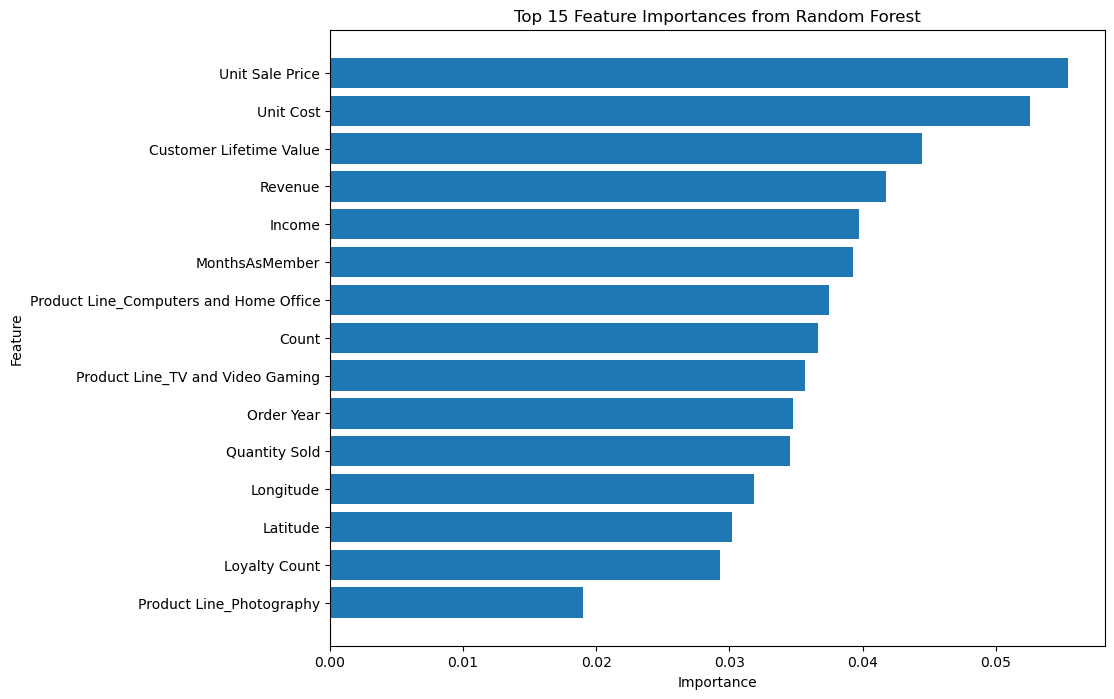

                                    feature  importance
7                           Unit Sale Price    0.055427
8                                 Unit Cost    0.052587
10                  Customer Lifetime Value    0.044455
9                                   Revenue    0.041764
2                                    Income    0.039724
4                            MonthsAsMember    0.039291
414  Product Line_Computers and Home Office    0.037452
5                                     Count    0.036663
418        Product Line_TV and Video Gaming    0.035713
3                                Order Year    0.034811
6                             Quantity Sold    0.034567
1                                 Longitude    0.031841
0                                  Latitude    0.030193
11                            Loyalty Count    0.029310
416                Product Line_Photography    0.019012


In [132]:
# Select top 15 features
top_15_features = feature_importances.head(15)

# Plot top 15 feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_15_features['feature'], top_15_features['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()

# Display the top 15 sorted feature importances
print(top_15_features)

In [3]:
df_new = pd.read_csv("df_with_original_categorical.csv")
df_new.head(2)

,Latitude,Longitude,Income,Order Year,MonthsAsMember,Count,Quantity Sold,Unit Sale Price,Unit Cost,Revenue,...,City,Postal code,Gender,Education,Location Code,Marital Status,Quarter,LoyaltyStatus,Product Line,Coupon Response
0,0.954747,-1.225422,-0.072900,-1.516170,0.370466,0.000000,-0.267581,-1.308948,-1.308948,-0.463616,...,Edmonton,T3G 6Y6,male,Bachelor,Rural,Married,Q1,Elite,Kitchen Appliances,Coupon 4
1,0.754316,-0.783250,-0.911481,-0.335719,-0.690512,-0.144111,0.647747,-0.444659,-0.596871,0.080603,...,Regina,91121,female,High School or Below,Urban,Divorced,Q1,VIP,Computers and Home Office,Coupon 3


Now let's make the Q-table using the features we got and provide them as a states.

We start by defining the states and action. States are the top 15 values that we 

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from collections import defaultdict

# Define the feature set including the top 15 features identified
features = [
    'Unit Sale Price', 'Unit Cost', 'Customer Lifetime Value', 'Revenue', 'Income', 
    'MonthsAsMember', 'Count', 'Order Year', 'Quantity Sold', 
    'Longitude', 'Latitude', 'Loyalty Count'
]
categorical_features = ['Product Line']

# Define actions as reward points
actions = [0, 10, 20, 30, 50]  # Points to reward

# Initialize the Q-table as a dictionary
q_table = defaultdict(lambda: np.zeros(len(actions)))

# Hyperparameters
learning_rate = 0.1
discount_factor = 0.99
epsilon = 0.1  # For exploration

# Define reward function (example)
def reward_function(state, action):
    # Custom reward logic based on state and action
    if action == 50:
        return 10
    elif action == 30:
        return 5
    elif action == 20:
        return 3
    elif action == 10:
        return 1
    else:
        return 0


# Define the target variable
target = 'LoyaltyStatus'

# Separate features and target
X = df_new[features + categorical_features]
y = df_new[target]

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-Hot Encode Categorical Variables
encoder = OneHotEncoder(sparse=False)
encoded_cats = encoder.fit_transform(X[categorical_features])
cat_feature_names = encoder.get_feature_names_out(categorical_features)

# Combine numerical and categorical features
X_combined = np.hstack((X[features].values, encoded_cats))

# Q-learning algorithm
num_episodes = 1000
max_steps_per_episode = 100

exploration_count = 0
exploitation_count = 0

for episode in range(num_episodes):
    # Initialize state (randomly select a customer)
    state_index = np.random.choice(len(X_combined))
    state = tuple(X_combined[state_index])
    
    for step in range(max_steps_per_episode):
        if np.random.rand() < epsilon:
            action_index = np.random.choice(len(actions))  # Explore
            exploration_count += 1
        else:
            action_index = np.argmax(q_table[state])  # Exploit
            exploitation_count += 1
        
        action = actions[action_index]
        
        # Get reward
        reward = reward_function(state, action)
        
        # Get next state (simplified: next state is the next sample in the training set)
        next_state_index = (state_index + 1) % len(X_combined)
        next_state = tuple(X_combined[next_state_index])
        
        # Update Q-table
        old_value = q_table[state][action_index]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - learning_rate) * old_value + learning_rate * (reward + discount_factor * next_max)
        q_table[state][action_index] = new_value
        
        # Debugging logs
        print(f"Episode: {episode}, Step: {step}, State: {state}, Action: {action}, Reward: {reward}, Old Q: {old_value}, New Q: {new_value} \n")
        
        # Move to next state
        state = next_state
    
    if (episode + 1) % 100 == 0:
        print(f"After {episode + 1} episodes:")
        print(f"Exploration count: {exploration_count}")
        print(f"Exploitation count: {exploitation_count}")

# Function to choose the best action based on the Q-table
def choose_action(state):
    state = tuple(state)
    action_index = np.argmax(q_table[state])
    return actions[action_index]

# Example usage of the policy
for i in range(10):
    state_index = np.random.choice(len(X_combined))
    state = X_combined[state_index]
    action = choose_action(state)
    print(f'State: {state}, Action: {action} points \n')


Episode: 0, Step: 0, State: (0.0990998148918151, 0.0342305041849613, -0.1003202572464943, 0.5799935460090637, -0.8981695175170898, -0.1890232264995575, 0.3237829208374023, 0.0980008393526077, 0.9161603450775146, -0.9750377535820008, 0.7602067589759827, 0.4039303064346313, 0.0, 0.0, 1.0, 0.0, 0.0), Action: 0, Reward: 0, Old Q: 0.0, New Q: 0.0 

Episode: 0, Step: 1, State: (0.5752059930297577, 0.5752059930297578, -0.103519788652403, 0.6559575245747357, -1.240808849529848, -0.2532760638992045, 0.0, -0.664756887466237, 0.5235521193301731, 0.8700092192181476, 0.6820833987735232, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0), Action: 0, Reward: 0, Old Q: 0.0, New Q: 0.0 

Episode: 0, Step: 2, State: (0.5752059930297577, 0.5752059930297578, -0.103519788652403, 0.6559575245747357, -1.240808849529848, -0.2532760638992045, 0.0, -0.664756887466237, 0.5235521193301731, 0.8700092192181476, 0.6820833987735232, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0), Action: 0, Reward: 0, Old Q: 0.0, New Q: 0.0 

Episode: 0, Step: 3, State: 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42)

In [13]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42)

# Neural network model for DQN
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Hyperparameters
learning_rate = 0.001
discount_factor = 0.99
epsilon = 0.1  # For exploration
batch_size = 64
target_update = 10  # How often to update the target network
num_episodes = 1000
max_steps_per_episode = 100

# Experience replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = [], [], [], [], []
        
        for state, action, reward, next_state, done in batch:
            state_batch.append(state)
            action_batch.append([action])  # Wrap action in a list to maintain consistent dimensions
            reward_batch.append([reward])
            next_state_batch.append(next_state)
            done_batch.append([done])
        
        return (
            torch.cat(state_batch).to(device),
            torch.tensor(action_batch, dtype=torch.int64).to(device),
            torch.tensor(reward_batch, dtype=torch.float32).to(device),
            torch.cat(next_state_batch).to(device),
            torch.tensor(done_batch, dtype=torch.float32).to(device)
        )
    
    def __len__(self):
        return len(self.buffer)

# Initialize models and optimizers
input_dim = X_train.shape[1]
output_dim = len(actions)
policy_net = DQN(input_dim, output_dim).to(device)
target_net = DQN(input_dim, output_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)
replay_buffer = ReplayBuffer(10000)

# Training loop
exploration_count = 0
exploitation_count = 0

def reward_function(state, action):
    if action == 50:
        return 10
    elif action == 30:
        return 5
    elif action == 20:
        return 3
    elif action == 10:
        return 1
    else:
        return 0

for episode in range(num_episodes):
    state_index = np.random.choice(len(X_train))
    state = torch.FloatTensor(X_train[state_index]).unsqueeze(0).to(device)
    
    for step in range(max_steps_per_episode):
        if np.random.rand() < epsilon:
            action_index = np.random.choice(len(actions))  # Explore
            exploration_count += 1
        else:
            with torch.no_grad():
                q_values = policy_net(state)
                action_index = q_values.argmax().item()  # Exploit
            exploitation_count += 1
        
        action = actions[action_index]
        next_state_index = (state_index + 1) % len(X_train)
        next_state = torch.FloatTensor(X_train[next_state_index]).unsqueeze(0).to(device)
        
        # Get reward
        reward = reward_function(state, action)
        
        # Check if episode is done
        done = step == max_steps_per_episode - 1
        
        # Store transition in replay buffer
        replay_buffer.push(state, action_index, reward, next_state, done)
        
        state = next_state
        
        # Sample random batch from replay buffer
        if len(replay_buffer) > batch_size:
            batch = replay_buffer.sample(batch_size)
            state_batch, action_batch, reward_batch, next_state_batch, done_batch = batch
            
            q_values = policy_net(state_batch).gather(1, action_batch).squeeze(1)
            next_q_values = target_net(next_state_batch).max(1)[0]
            expected_q_values = reward_batch.squeeze(1) + discount_factor * next_q_values * (1 - done_batch.squeeze(1))
            
            loss = nn.MSELoss()(q_values, expected_q_values)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if step % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())
    
    if episode % 100 == 0:
        print(f"After {episode} episodes:")
        print(f"Exploration count: {exploration_count}")
        print(f"Exploitation count: {exploitation_count}")
        print()

# Function to choose the best action based on the DQN
def choose_action(state):
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    with torch.no_grad():
        q_values = policy_net(state)
        action_index = q_values.argmax().item()
    return actions[action_index]

# Example usage of the policy
for i in range(10):
    state_index = np.random.choice(len(X_test))
    state = X_test[state_index]
    action = choose_action(state)
    print(f'State: {state}, Action: {action} points \n')

# Save the policy network for future use
torch.save(policy_net.state_dict(), 'dqn_policy_net.pth')

# Load the policy network (if needed later)
policy_net.load_state_dict(torch.load('dqn_policy_net.pth'))


After 0 episodes:
Exploration count: 16
Exploitation count: 84
After 100 episodes:
Exploration count: 975
Exploitation count: 9125
After 200 episodes:
Exploration count: 2029
Exploitation count: 18071
After 300 episodes:
Exploration count: 3022
Exploitation count: 27078
After 400 episodes:
Exploration count: 4023
Exploitation count: 36077
After 500 episodes:
Exploration count: 5055
Exploitation count: 45045
After 600 episodes:
Exploration count: 6036
Exploitation count: 54064
After 700 episodes:
Exploration count: 6965
Exploitation count: 63135
After 800 episodes:
Exploration count: 8014
Exploitation count: 72086
After 900 episodes:
Exploration count: 9054
Exploitation count: 81046
State: [-0.91272169 -0.91272169 -0.21739521 -0.33778287 -1.24080885  0.54867792
  0.          1.03806943 -0.10935476 -1.40473375  0.39397332  0.
  0.          0.          0.          0.          1.        ], Action: 20 points
State: [ 0.56885564  0.97381717  0.75550115  0.13327037 -0.8891077   0.1057566
 -0.

<All keys matched successfully>